Import important parameter

In [1]:
inputsize =15**2
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)
sqrtinputsize = int(np.sqrt(inputsize))     
sqrtoutputsize = int(sqrtinputsize/2)
outputsize = int(sqrtoutputsize**2)
h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R = Restriction(inputsize)
P = 4*np.transpose(R)

Linear = 0.2324857876268527


GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 17.63527099753229
Interation = 1
Residual = 3.630378296110373
Interation = 2
Residual = 1.1990372301498295
Interation = 3
Residual = 0.42508549422302666
Interation = 4
Residual = 0.15867291470540845
Interation = 5
Residual = 0.061512446809066236
Interation = 6
Residual = 0.02451134690138648
Interation = 7
Residual = 0.009969024104577846
Interation = 8
Residual = 0.0041195659568915785
Interation = 9
Residual = 0.0017247111268662771
Interation = 10
Residual = 0.0007301876220109459
Interation = 11
Residual = 0.0003122056166260349
Interation = 12
Residual = 0.00013468104759882432
Interation = 13
Residual = 5.857026956351296e-05
Interation = 14
Residual = 2.5659008576701042e-05
Interation = 15
Residual = 1.1316382555094236e-05
Interation = 16
Residual = 5.021274292733788e-06
Interation = 17
Residual = 2.2403257151751945e-06
Interation = 18
Residual = 1.004547975213007e-06
Interation = 19
Residual = 4.5246342448221284e-07
Interation = 20
Residual = 2.0462568366974737e-07
Interatio

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
3.069779058010629
L2 norm: 
0.22159479672944693
H1 norm: 
2.250716489306729
Energy norm: 
0.2650631681447637
L2 norm: 
0.44318959345889386
H1 norm: 
0.27399491120201214


Solution

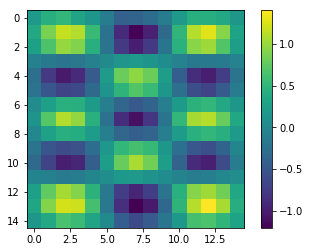

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

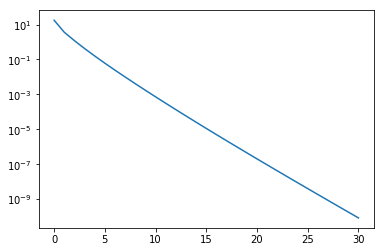

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.47197473198040524


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-4,accept_radius =
                                                           GMM_Radius*10,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.44181084150845573
L = 0.03
rho = 0.4418191287595547
L = 0.04
rho = 0.4418621133161784
L = 0.05
rho = 0.4419373290973905
L = 0.060000000000000005
rho = 0.44204232609751826
L = 0.07
rho = 0.4421746978183069
L = 0.08
rho = 0.44233210475651163
L = 0.09
rho = 0.44251229363425526
L = 0.09999999999999999
rho = 0.44271311234390437
L = 0.10999999999999999
rho = 0.4429325208025265
L = 0.11999999999999998
rho = 0.44316859806973624
L = 0.12999999999999998
rho = 0.44341954618098356
L = 0.13999999999999999
rho = 0.4436836911948846
L = 0.15
rho = 0.44395948195903157
L = 0.16
rho = 0.4442454870750957
L = 0.17
rho = 0.44454039050120325
L = 0.18000000000000002
rho = 0.44484298617605206
L = 0.19000000000000003
rho = 0.44515217199163326
L = 0.20000000000000004
rho = 0.44546694338446885
L = 0.21000000000000005
rho = 0.44578638676205873
L = 0.22000000000000006
rho = 0.4461096729335713
L = 0.23000000000000007
rho = 0.4464360506725126
L = 0.24000000000000007
rho = 0.4467

the 26 steps
rho = 0.4641115846117699
the 27 steps
rho = 0.4640431088044987
the 28 steps
rho = 0.46397467292588246
the 29 steps
rho = 0.46390627686303754
the 30 steps
rho = 0.4638379205037644
the 31 steps
rho = 0.46376960373653925
the 32 steps
rho = 0.46370132645050777
the 33 steps
rho = 0.4636330885354768
the 34 steps
rho = 0.4635648898819084
the 35 steps
rho = 0.46349673038091227
the 36 steps
rho = 0.46342860992423884
the 37 steps
rho = 0.46336052840427255
the 38 steps
rho = 0.46329248571402554
the 39 steps
rho = 0.46322448174713027
the 40 steps
rho = 0.4631565163978334
the 41 steps
rho = 0.4630885895609894
the 42 steps
rho = 0.46302070113205385
the 43 steps
rho = 0.46295285100707717
the 44 steps
rho = 0.46288503908269873
the 45 steps
rho = 0.4628172652561403
the 46 steps
rho = 0.46274952942519987
the 47 steps
rho = 0.46268183148824626
the 48 steps
rho = 0.4626141713442123
the 49 steps
rho = 0.46254654889258956
the 50 steps
rho = 0.4624789640334227
the 51 steps
rho = 0.46241141666730

the 165 steps
rho = 0.4549348443686614
the 166 steps
rho = 0.45487105435692093
the 167 steps
rho = 0.45480729292160055
the 168 steps
rho = 0.45474356000170835
the 169 steps
rho = 0.4546798555364454
the 170 steps
rho = 0.4546161794652044
the 171 steps
rho = 0.45455253172756815
the 172 steps
rho = 0.45448891226330856
the 173 steps
rho = 0.4544253210123853
the 174 steps
rho = 0.4543617579149441
the 175 steps
rho = 0.4542982229113163
the 176 steps
rho = 0.45423471594201653
the 177 steps
rho = 0.45417123694774286
the 178 steps
rho = 0.45410778586937417
the 179 steps
rho = 0.45404436264796977
the 180 steps
rho = 0.4539809672247681
the 181 steps
rho = 0.45391759954118555
the 182 steps
rho = 0.45385425953881536
the 183 steps
rho = 0.4537909471594258
the 184 steps
rho = 0.45372766234496
the 185 steps
rho = 0.4536644050375346
the 186 steps
rho = 0.45360117517943815
the 187 steps
rho = 0.4535379727131306
the 188 steps
rho = 0.4534747975812416
the 189 steps
rho = 0.45341164972657017
the 190 steps


the 306 steps
rho = 0.4461972003505877
the 307 steps
rho = 0.4461369100617188
the 308 steps
rho = 0.4460766412262684
the 309 steps
rho = 0.4460163938022054
the 310 steps
rho = 0.44595616774759766
the 311 steps
rho = 0.4458959630206119
the 312 steps
rho = 0.44583577957951315
the 313 steps
rho = 0.4457756173826647
the 314 steps
rho = 0.44571547638852776
the 315 steps
rho = 0.44565535655566096
the 316 steps
rho = 0.4455952578427207
the 317 steps
rho = 0.44553518020846
the 318 steps
rho = 0.4454751236117292
the 319 steps
rho = 0.44541508801147467
the 320 steps
rho = 0.4453550733667395
the 321 steps
rho = 0.44529507963666265
the 322 steps
rho = 0.4452351067804789
the 323 steps
rho = 0.44517515475751857
the 324 steps
rho = 0.4451152235272071
the 325 steps
rho = 0.4450553130490653
the 326 steps
rho = 0.44499542328270836
the 327 steps
rho = 0.4449355541878463
the 328 steps
rho = 0.4448757057242834
the 329 steps
rho = 0.4448158778519179
the 330 steps
rho = 0.4447560705307419
the 331 steps
rho =

the 446 steps
rho = 0.4379479089784756
the 447 steps
rho = 0.4378902540293603
the 448 steps
rho = 0.4378326155155607
the 449 steps
rho = 0.4377749934069509
the 450 steps
rho = 0.4377173876734803
the 451 steps
rho = 0.43765979828517226
the 452 steps
rho = 0.43760222521212466
the 453 steps
rho = 0.43754466842450956
the 454 steps
rho = 0.4374871278925731
the 455 steps
rho = 0.43742960358663574
the 456 steps
rho = 0.43737209547709127
the 457 steps
rho = 0.4373146035344078
the 458 steps
rho = 0.4372571277291269
the 459 steps
rho = 0.4371996680318635
the 460 steps
rho = 0.4371422244133063
the 461 steps
rho = 0.43708479684421686
the 462 steps
rho = 0.43702738529543045
the 463 steps
rho = 0.436969989737855
the 464 steps
rho = 0.4369126101424717
the 465 steps
rho = 0.43685524648033436
the 466 steps
rho = 0.4367978987225696
the 467 steps
rho = 0.4367405668403769
the 468 steps
rho = 0.4366832508050278
the 469 steps
rho = 0.4366259505878668
the 470 steps
rho = 0.43656866616031015
the 471 steps
rho

the 586 steps
rho = 0.430023744229789
the 587 steps
rho = 0.4299681287552881
the 588 steps
rho = 0.4299125261739394
the 589 steps
rho = 0.4298569364649712
the 590 steps
rho = 0.42980135960767124
the 591 steps
rho = 0.4297457955813857
the 592 steps
rho = 0.4296902443655198
the 593 steps
rho = 0.4296347059395373
the 594 steps
rho = 0.4295791802829606
the 595 steps
rho = 0.42952366737537023
the 596 steps
rho = 0.42946816719640546
the 597 steps
rho = 0.4294126797257633
the 598 steps
rho = 0.42935720494319923
the 599 steps
rho = 0.42930174282852657
the 600 steps
rho = 0.4292462933616164
the 601 steps
rho = 0.42919085652239763
the 602 steps
rho = 0.4291354322908567
the 603 steps
rho = 0.4290800206470378
the 604 steps
rho = 0.42902462157104215
the 605 steps
rho = 0.4289692350430286
the 606 steps
rho = 0.42891386104321305
the 607 steps
rho = 0.4288584995518685
the 608 steps
rho = 0.4288031505493247
the 609 steps
rho = 0.4287478140159684
the 610 steps
rho = 0.4286924899322431
the 611 steps
rho 

the 725 steps
rho = 0.4224085863393733
the 726 steps
rho = 0.42235458792736114
the 727 steps
rho = 0.42230060003686326
the 728 steps
rho = 0.42224662265420715
the 729 steps
rho = 0.42219265576576376
the 730 steps
rho = 0.4221386993579464
the 731 steps
rho = 0.42208475341721174
the 732 steps
rho = 0.422030817930059
the 733 steps
rho = 0.42197689288302975
the 734 steps
rho = 0.42192297826270825
the 735 steps
rho = 0.4218690740557211
the 736 steps
rho = 0.4218151802487372
the 737 steps
rho = 0.42176129682846747
the 738 steps
rho = 0.421707423781665
the 739 steps
rho = 0.42165356109512464
the 740 steps
rho = 0.42159970875568314
the 741 steps
rho = 0.421545866750219
the 742 steps
rho = 0.4214920350656524
the 743 steps
rho = 0.4214382136889446
the 744 steps
rho = 0.42138440260709853
the 745 steps
rho = 0.42133060180715826
the 746 steps
rho = 0.4212768112762092
the 747 steps
rho = 0.42122303100137753
the 748 steps
rho = 0.42116926096983043
the 749 steps
rho = 0.42111550116877605
the 750 steps

the 865 steps
rho = 0.41494567741822186
the 866 steps
rho = 0.41489303657224846
the 867 steps
rho = 0.4148404047038827
the 868 steps
rho = 0.4147877818044391
the 869 steps
rho = 0.41473516786526055
the 870 steps
rho = 0.41468256287771865
the 871 steps
rho = 0.4146299668332133
the 872 steps
rho = 0.41457737972317277
the 873 steps
rho = 0.41452480153905363
the 874 steps
rho = 0.4144722322723407
the 875 steps
rho = 0.41441967191454654
the 876 steps
rho = 0.4143671204572121
the 877 steps
rho = 0.41431457789190596
the 878 steps
rho = 0.41426204421022444
the 879 steps
rho = 0.41420951940379197
the 880 steps
rho = 0.4141570034642602
the 881 steps
rho = 0.4141044963833086
the 882 steps
rho = 0.41405199815264376
the 883 steps
rho = 0.41399950876400005
the 884 steps
rho = 0.41394702820913865
the 885 steps
rho = 0.41389455647984846
the 886 steps
rho = 0.41384209356794505
the 887 steps
rho = 0.4137896394652711
the 888 steps
rho = 0.4137371941636964
the 889 steps
rho = 0.4136847576551173
the 890 st

the 1005 steps
rho = 0.40765982634092623
the 1006 steps
rho = 0.4076083693511794
the 1007 steps
rho = 0.40755692036402114
the 1008 steps
rho = 0.40750547937398146
the 1009 steps
rho = 0.4074540463756078
the 1010 steps
rho = 0.4074026213634658
the 1011 steps
rho = 0.40735120433213884
the 1012 steps
rho = 0.40729979527622795
the 1013 steps
rho = 0.4072483941903518
the 1014 steps
rho = 0.40719700106914686
the 1015 steps
rho = 0.4071456159072668
the 1016 steps
rho = 0.407094238699383
the 1017 steps
rho = 0.4070428694401842
the 1018 steps
rho = 0.4069915081243767
the 1019 steps
rho = 0.40694015474668366
the 1020 steps
rho = 0.40688880930184584
the 1021 steps
rho = 0.40683747178462104
the 1022 steps
rho = 0.4067861421897842
the 1023 steps
rho = 0.4067348205121273
the 1024 steps
rho = 0.40668350674645926
the 1025 steps
rho = 0.40663220088760604
the 1026 steps
rho = 0.40658090293041055
the 1027 steps
rho = 0.4065296128697322
the 1028 steps
rho = 0.4064783307004476
the 1029 steps
rho = 0.406427

the 1144 steps
rho = 0.40058190500930363
the 1145 steps
rho = 0.4005315149044761
the 1146 steps
rho = 0.4004811321890527
the 1147 steps
rho = 0.40043075685953317
the 1148 steps
rho = 0.40038038891242783
the 1149 steps
rho = 0.4003300283442585
the 1150 steps
rho = 0.40027967515155716
the 1151 steps
rho = 0.40022932933086686
the 1152 steps
rho = 0.4001789908787416
the 1153 steps
rho = 0.40012865979174583
the 1154 steps
rho = 0.4000783360664547
the 1155 steps
rho = 0.4000280196994542
the 1156 steps
rho = 0.3999777106873406
the 1157 steps
rho = 0.3999274090267212
the 1158 steps
rho = 0.39987711471421344
the 1159 steps
rho = 0.3998268277464451
the 1160 steps
rho = 0.39977654812005514
the 1161 steps
rho = 0.3997262758316921
the 1162 steps
rho = 0.39967601087801546
the 1163 steps
rho = 0.39962575325569477
the 1164 steps
rho = 0.39957550296141003
the 1165 steps
rho = 0.39952525999185123
the 1166 steps
rho = 0.39947502434371907
the 1167 steps
rho = 0.3994247960137239
the 1168 steps
rho = 0.3993

the 1280 steps
rho = 0.3937953858619606
the 1281 steps
rho = 0.39374597256828875
the 1282 steps
rho = 0.39369656627378113
the 1283 steps
rho = 0.3936471669761124
the 1284 steps
rho = 0.3935977746729636
the 1285 steps
rho = 0.39354838936202297
the 1286 steps
rho = 0.39349901104098484
the 1287 steps
rho = 0.3934496397075506
the 1288 steps
rho = 0.3934002753594281
the 1289 steps
rho = 0.3933509179943316
the 1290 steps
rho = 0.393301567609982
the 1291 steps
rho = 0.3932522242041068
the 1292 steps
rho = 0.39320288777444024
the 1293 steps
rho = 0.39315355831872245
the 1294 steps
rho = 0.3931042358347004
the 1295 steps
rho = 0.3930549203201276
the 1296 steps
rho = 0.39300561177276366
the 1297 steps
rho = 0.39295631019037486
the 1298 steps
rho = 0.3929070155707336
the 1299 steps
rho = 0.39285772791161894
the 1300 steps
rho = 0.392808447210816
the 1301 steps
rho = 0.3927591734661163
the 1302 steps
rho = 0.3927099066753176
the 1303 steps
rho = 0.392660646836224
the 1304 steps
rho = 0.39261139394

the 1418 steps
rho = 0.38704160636478985
the 1419 steps
rho = 0.3869931395363922
the 1420 steps
rho = 0.3869446794407333
the 1421 steps
rho = 0.386896226076227
the 1422 steps
rho = 0.38684777944129123
the 1423 steps
rho = 0.3867993395343484
the 1424 steps
rho = 0.3867509063538252
the 1425 steps
rho = 0.3867024798981523
the 1426 steps
rho = 0.3866540601657647
the 1427 steps
rho = 0.38660564715510165
the 1428 steps
rho = 0.38655724086460663
the 1429 steps
rho = 0.38650884129272717
the 1430 steps
rho = 0.38646044843791516
the 1431 steps
rho = 0.3864120622986263
the 1432 steps
rho = 0.38636368287332096
the 1433 steps
rho = 0.3863153101604632
the 1434 steps
rho = 0.3862669441585215
the 1435 steps
rho = 0.3862185848659682
the 1436 steps
rho = 0.38617023228127995
the 1437 steps
rho = 0.3861218864029374
the 1438 steps
rho = 0.3860735472294253
the 1439 steps
rho = 0.38602521475923246
the 1440 steps
rho = 0.3859768889908517
the 1441 steps
rho = 0.3859285699227801
the 1442 steps
rho = 0.385880257

the 1554 steps
rho = 0.3805113282440559
the 1555 steps
rho = 0.38046376411818766
the 1556 steps
rho = 0.3804162065445568
the 1557 steps
rho = 0.38036865552207716
the 1558 steps
rho = 0.3803211110496658
the 1559 steps
rho = 0.3802735731262431
the 1560 steps
rho = 0.3802260417507329
the 1561 steps
rho = 0.38017851692206217
the 1562 steps
rho = 0.3801309986391614
the 1563 steps
rho = 0.3800834869009642
the 1564 steps
rho = 0.3800359817064079
the 1565 steps
rho = 0.3799884830544326
the 1566 steps
rho = 0.37994099094398237
the 1567 steps
rho = 0.3798935053740042
the 1568 steps
rho = 0.3798460263434483
the 1569 steps
rho = 0.37979855385126865
the 1570 steps
rho = 0.3797510878964222
the 1571 steps
rho = 0.37970362847786965
the 1572 steps
rho = 0.37965617559457443
the 1573 steps
rho = 0.379608729245504
the 1574 steps
rho = 0.37956128942962863
the 1575 steps
rho = 0.37951385614592237
the 1576 steps
rho = 0.3794664293933622
the 1577 steps
rho = 0.37941900917092874
the 1578 steps
rho = 0.37937159

the 1690 steps
rho = 0.37410235878332065
the 1691 steps
rho = 0.3740556772670374
the 1692 steps
rho = 0.374009002191015
the 1693 steps
rho = 0.3739623335548337
the 1694 steps
rho = 0.37391567135808484
the 1695 steps
rho = 0.3738690156003712
the 1696 steps
rho = 0.3738223662813079
the 1697 steps
rho = 0.3737757234005214
the 1698 steps
rho = 0.37372908695765145
the 1699 steps
rho = 0.3736824569523498
the 1700 steps
rho = 0.3736358333842819
the 1701 steps
rho = 0.3735892162531263
the 1702 steps
rho = 0.3735426055585752
the 1703 steps
rho = 0.37349600130033545
the 1704 steps
rho = 0.37344940347812783
the 1705 steps
rho = 0.3734028120916884
the 1706 steps
rho = 0.3733562271407684
the 1707 steps
rho = 0.37330964862513477
the 1708 steps
rho = 0.3732630765445708
the 1709 steps
rho = 0.37321651089887614
the 1710 steps
rho = 0.3731699516878677
the 1711 steps
rho = 0.3731233989113796
the 1712 steps
rho = 0.3730768525692644
the 1713 steps
rho = 0.37303031266139286
the 1714 steps
rho = 0.3729837791

the 1827 steps
rho = 0.36776725650322944
the 1828 steps
rho = 0.36772147188006504
the 1829 steps
rho = 0.3676756943364414
the 1830 steps
rho = 0.3676299238965063
the 1831 steps
rho = 0.36758416058525084
the 1832 steps
rho = 0.3675384044285379
the 1833 steps
rho = 0.3674926554531327
the 1834 steps
rho = 0.3674469136867328
the 1835 steps
rho = 0.36740117915800063
the 1836 steps
rho = 0.36735545189659624
the 1837 steps
rho = 0.36730973193321115
the 1838 steps
rho = 0.36726401929960417
the 1839 steps
rho = 0.36721831402863736
the 1840 steps
rho = 0.36717261615431396
the 1841 steps
rho = 0.3671269257118174
the 1842 steps
rho = 0.3670812427375514
the 1843 steps
rho = 0.36703556726918163
the 1844 steps
rho = 0.36698989934567927
the 1845 steps
rho = 0.3669442390073648
the 1846 steps
rho = 0.36689858629595445
the 1847 steps
rho = 0.366852941254608
the 1848 steps
rho = 0.36680730392797706
the 1849 steps
rho = 0.3667616743622573
the 1850 steps
rho = 0.36671605260523976
the 1851 steps
rho = 0.3666

the 1965 steps
rho = 0.36156786968518406
the 1966 steps
rho = 0.3615250170494561
the 1967 steps
rho = 0.3614822377948513
the 1968 steps
rho = 0.36143953394711137
the 1969 steps
rho = 0.36139690758452314
the 1970 steps
rho = 0.3613543608387414
the 1971 steps
rho = 0.3613118958955904
the 1972 steps
rho = 0.3612695149958393
the 1973 steps
rho = 0.36122722043594996
the 1974 steps
rho = 0.36118501456879243
the 1975 steps
rho = 0.3611428998043267
the 1976 steps
rho = 0.36110087861024537
the 1977 steps
rho = 0.36105895351257533
the 1978 steps
rho = 0.3610171270962335
the 1979 steps
rho = 0.3609754020055335
the 1980 steps
rho = 0.36093378094463974
the 1981 steps
rho = 0.36089226667796276
the 1982 steps
rho = 0.36085086203049527
the 1983 steps
rho = 0.3608095698880802
the 1984 steps
rho = 0.3607683931976104
the 1985 steps
rho = 0.36072733496715254
the 1986 steps
rho = 0.3606863982659923
the 1987 steps
rho = 0.3606455862245957
the 1988 steps
rho = 0.3606049020344811
the 1989 steps
rho = 0.360564

the 2103 steps
rho = 0.3576129337814735
the 2104 steps
rho = 0.3576031153193961
the 2105 steps
rho = 0.3575934578058239
the 2106 steps
rho = 0.35758395638558443
the 2107 steps
rho = 0.35757460628008797
the 2108 steps
rho = 0.35756540279081755
the 2109 steps
rho = 0.35755634130246655
the 2110 steps
rho = 0.35754741728573214
the 2111 steps
rho = 0.3575386262997734
the 2112 steps
rho = 0.3575299639943447
the 2113 steps
rho = 0.3575214261116146
the 2114 steps
rho = 0.3575130084876831
the 2115 steps
rho = 0.35750470705380966
the 2116 steps
rho = 0.35749651783736525
the 2117 steps
rho = 0.35748843696252164
the 2118 steps
rho = 0.3574804606506919
the 2119 steps
rho = 0.3574725852207373
the 2120 steps
rho = 0.3574648070889528
the 2121 steps
rho = 0.35745712276884695
the 2122 steps
rho = 0.35744952887072945
the 2123 steps
rho = 0.35744202210112025
the 2124 steps
rho = 0.35743459926199384
the 2125 steps
rho = 0.35742725724987234
the 2126 steps
rho = 0.35741999305477967
the 2127 steps
rho = 0.357

the 2239 steps
rho = 0.3567681569941228
the 2240 steps
rho = 0.35676279865037147
the 2241 steps
rho = 0.35675744222349537
the 2242 steps
rho = 0.35675208769449696
the 2243 steps
rho = 0.3567467350452005
the 2244 steps
rho = 0.3567413842582131
the 2245 steps
rho = 0.3567360353168876
the 2246 steps
rho = 0.356730688205287
the 2247 steps
rho = 0.35672534290815233
the 2248 steps
rho = 0.3567199994108687
the 2249 steps
rho = 0.35671465769943667
the 2250 steps
rho = 0.356709317760442
the 2251 steps
rho = 0.35670397958102895
the 2252 steps
rho = 0.3566986431488736
the 2253 steps
rho = 0.35669330845215896
the 2254 steps
rho = 0.3566879754795509
the 2255 steps
rho = 0.3566826442201757
the 2256 steps
rho = 0.35667731466359875
the 2257 steps
rho = 0.3566719867998033
the 2258 steps
rho = 0.3566666606191713
the 2259 steps
rho = 0.3566613361124649
the 2260 steps
rho = 0.35665601327080826
the 2261 steps
rho = 0.356650692085671
the 2262 steps
rho = 0.35664537254885187
the 2263 steps
rho = 0.3566400546

the 2376 steps
rho = 0.35604875458596763
the 2377 steps
rho = 0.3560436024237621
the 2378 steps
rho = 0.3560384516220892
the 2379 steps
rho = 0.3560333021798423
the 2380 steps
rho = 0.35602815409591865
the 2381 steps
rho = 0.3560230073692194
the 2382 steps
rho = 0.3560178619986498
the 2383 steps
rho = 0.35601271798311884
the 2384 steps
rho = 0.3560075753215391
the 2385 steps
rho = 0.356002434012827
the 2386 steps
rho = 0.35599729405590247
the 2387 steps
rho = 0.3559921554496889
the 2388 steps
rho = 0.3559870181931132
the 2389 steps
rho = 0.3559818822851058
the 2390 steps
rho = 0.3559767477246
the 2391 steps
rho = 0.35597161451053283
the 2392 steps
rho = 0.35596648264184444
the 2393 steps
rho = 0.3559613521174779
the 2394 steps
rho = 0.3559562229363794
the 2395 steps
rho = 0.35595109509749845
the 2396 steps
rho = 0.3559459685997871
the 2397 steps
rho = 0.3559408434422007
the 2398 steps
rho = 0.3559357196236973
the 2399 steps
rho = 0.3559305971432378
the 2400 steps
rho = 0.35592547599978

the 2512 steps
rho = 0.35536013372762576
the 2513 steps
rho = 0.3553551574775296
the 2514 steps
rho = 0.355350182458135
the 2515 steps
rho = 0.3553452086685826
the 2516 steps
rho = 0.355340236108014
the 2517 steps
rho = 0.3553352647755716
the 2518 steps
rho = 0.35533029467039884
the 2519 steps
rho = 0.3553253257916403
the 2520 steps
rho = 0.35532035813844126
the 2521 steps
rho = 0.35531539170994814
the 2522 steps
rho = 0.35531042650530825
the 2523 steps
rho = 0.3553054625236698
the 2524 steps
rho = 0.355300499764182
the 2525 steps
rho = 0.3552955382259949
the 2526 steps
rho = 0.3552905779082597
the 2527 steps
rho = 0.3552856188101284
the 2528 steps
rho = 0.35528066093075367
the 2529 steps
rho = 0.3552757042692896
the 2530 steps
rho = 0.35527074882489096
the 2531 steps
rho = 0.3552657945967132
the 2532 steps
rho = 0.3552608415839133
the 2533 steps
rho = 0.3552558897856484
the 2534 steps
rho = 0.3552509392010771
the 2535 steps
rho = 0.3552459898293587
the 2536 steps
rho = 0.3552410416696

the 2648 steps
rho = 0.3546943213398737
the 2649 steps
rho = 0.3546895049362694
the 2650 steps
rho = 0.3546846896543742
the 2651 steps
rho = 0.3546798754934416
the 2652 steps
rho = 0.35467506245272556
the 2653 steps
rho = 0.3546702505314811
the 2654 steps
rho = 0.354665439728964
the 2655 steps
rho = 0.35466063004443066
the 2656 steps
rho = 0.35465582147713837
the 2657 steps
rho = 0.3546510140263452
the 2658 steps
rho = 0.3546462076913099
the 2659 steps
rho = 0.3546414024712921
the 2660 steps
rho = 0.35463659836555245
the 2661 steps
rho = 0.35463179537335193
the 2662 steps
rho = 0.35462699349395255
the 2663 steps
rho = 0.35462219272661716
the 2664 steps
rho = 0.35461739307060924
the 2665 steps
rho = 0.35461259452519317
the 2666 steps
rho = 0.3546077970896341
the 2667 steps
rho = 0.3546030007631979
the 2668 steps
rho = 0.35459820554515126
the 2669 steps
rho = 0.35459341143476186
the 2670 steps
rho = 0.35458861843129785
the 2671 steps
rho = 0.3545838265340283
the 2672 steps
rho = 0.354579

the 2786 steps
rho = 0.35403995276953015
the 2787 steps
rho = 0.3540352844495585
the 2788 steps
rho = 0.354030617156004
the 2789 steps
rho = 0.35402595088823674
the 2790 steps
rho = 0.354021285645628
the 2791 steps
rho = 0.3540166214275502
the 2792 steps
rho = 0.35401195823337633
the 2793 steps
rho = 0.3540072960624806
the 2794 steps
rho = 0.35400263491423806
the 2795 steps
rho = 0.3539979747880248
the 2796 steps
rho = 0.3539933156832178
the 2797 steps
rho = 0.35398865759919507
the 2798 steps
rho = 0.35398400053533546
the 2799 steps
rho = 0.3539793444910189
the 2800 steps
rho = 0.35397468946562627
the 2801 steps
rho = 0.3539700354585395
the 2802 steps
rho = 0.3539653824691413
the 2803 steps
rho = 0.3539607304968153
the 2804 steps
rho = 0.35395607954094666
the 2805 steps
rho = 0.3539514296009208
the 2806 steps
rho = 0.3539467806761245
the 2807 steps
rho = 0.3539421327659455
the 2808 steps
rho = 0.3539374858697726
the 2809 steps
rho = 0.3539328399869952
the 2810 steps
rho = 0.35392819511

the 2922 steps
rho = 0.35341423924495935
the 2923 steps
rho = 0.3534097051547374
the 2924 steps
rho = 0.35340517201487837
the 2925 steps
rho = 0.35340063982490166
the 2926 steps
rho = 0.35339610858432824
the 2927 steps
rho = 0.3533915782926798
the 2928 steps
rho = 0.3533870489494801
the 2929 steps
rho = 0.35338252055425334
the 2930 steps
rho = 0.35337799310652557
the 2931 steps
rho = 0.3533734666058239
the 2932 steps
rho = 0.35336894105167665
the 2933 steps
rho = 0.35336441644361366
the 2934 steps
rho = 0.3533598927811658
the 2935 steps
rho = 0.35335537006386536
the 2936 steps
rho = 0.3533508482912461
the 2937 steps
rho = 0.3533463274628426
the 2938 steps
rho = 0.3533418075781911
the 2939 steps
rho = 0.3533372886368291
the 2940 steps
rho = 0.3533327706382955
the 2941 steps
rho = 0.3533282535821301
the 2942 steps
rho = 0.3533237374678744
the 2943 steps
rho = 0.35331922229507107
the 2944 steps
rho = 0.35331470806326415
the 2945 steps
rho = 0.35331019477199893
the 2946 steps
rho = 0.35330

the 3059 steps
rho = 0.3528017398216195
the 3060 steps
rho = 0.3527973320238217
the 3061 steps
rho = 0.35279292512350613
the 3062 steps
rho = 0.3527885191203917
the 3063 steps
rho = 0.35278411401419907
the 3064 steps
rho = 0.35277970980465034
the 3065 steps
rho = 0.3527753064914693
the 3066 steps
rho = 0.35277090407438155
the 3067 steps
rho = 0.35276650255311437
the 3068 steps
rho = 0.35276210192739643
the 3069 steps
rho = 0.3527577021969583
the 3070 steps
rho = 0.35275330336153227
the 3071 steps
rho = 0.35274890542085213
the 3072 steps
rho = 0.3527445083746535
the 3073 steps
rho = 0.35274011222267365
the 3074 steps
rho = 0.35273571696465134
the 3075 steps
rho = 0.35273132260032736
the 3076 steps
rho = 0.35272692912944387
the 3077 steps
rho = 0.35272253655174496
the 3078 steps
rho = 0.35271814486697634
the 3079 steps
rho = 0.35271375407488537
the 3080 steps
rho = 0.3527093641752212
the 3081 steps
rho = 0.3527049751677345
the 3082 steps
rho = 0.35270058705217794
the 3083 steps
rho = 0.3

the 3196 steps
rho = 0.3522061389175701
the 3197 steps
rho = 0.35220185218940864
the 3198 steps
rho = 0.3521975663368119
the 3199 steps
rho = 0.3521932813597514
the 3200 steps
rho = 0.35218899725820085
the 3201 steps
rho = 0.35218471403213564
the 3202 steps
rho = 0.35218043168153335
the 3203 steps
rho = 0.35217615020637366
the 3204 steps
rho = 0.35217186960663804
the 3205 steps
rho = 0.3521675898823103
the 3206 steps
rho = 0.3521633110333761
the 3207 steps
rho = 0.35215903305982316
the 3208 steps
rho = 0.3521547559616413
the 3209 steps
rho = 0.35215047973882224
the 3210 steps
rho = 0.35214620439136
the 3211 steps
rho = 0.35214192991925053
the 3212 steps
rho = 0.3521376563224917
the 3213 steps
rho = 0.35213338360108354
the 3214 steps
rho = 0.35212911175502815
the 3215 steps
rho = 0.35212484078432976
the 3216 steps
rho = 0.35212057068899444
the 3217 steps
rho = 0.35211630146903056
the 3218 steps
rho = 0.35211203312444844
the 3219 steps
rho = 0.3521077656552604
the 3220 steps
rho = 0.3521

the 3333 steps
rho = 0.3516270311938072
the 3334 steps
rho = 0.3516228650304282
the 3335 steps
rho = 0.35161869975841775
the 3336 steps
rho = 0.35161453537804244
the 3337 steps
rho = 0.35161037188957134
the 3338 steps
rho = 0.35160620929327563
the 3339 steps
rho = 0.3516020475894288
the 3340 steps
rho = 0.35159788677830656
the 3341 steps
rho = 0.3515937268601869
the 3342 steps
rho = 0.35158956783535017
the 3343 steps
rho = 0.3515854097040787
the 3344 steps
rho = 0.35158125246665745
the 3345 steps
rho = 0.3515770961233734
the 3346 steps
rho = 0.3515729406745158
the 3347 steps
rho = 0.35156878612037623
the 3348 steps
rho = 0.3515646324612485
the 3349 steps
rho = 0.3515604796974288
the 3350 steps
rho = 0.3515563278292155
the 3351 steps
rho = 0.35155217685690904
the 3352 steps
rho = 0.35154802678081243
the 3353 steps
rho = 0.35154387760123085
the 3354 steps
rho = 0.35153972931847177
the 3355 steps
rho = 0.3515355819328448
the 3356 steps
rho = 0.3515314354446619
the 3357 steps
rho = 0.35152

the 3471 steps
rho = 0.35106067391539664
the 3472 steps
rho = 0.3510566342570837
the 3473 steps
rho = 0.35105259554848556
the 3474 steps
rho = 0.3510485577901839
the 3475 steps
rho = 0.3510445209827626
the 3476 steps
rho = 0.35104048512680813
the 3477 steps
rho = 0.3510364502229088
the 3478 steps
rho = 0.35103241627165555
the 3479 steps
rho = 0.3510283832736415
the 3480 steps
rho = 0.3510243512294621
the 3481 steps
rho = 0.3510203201397149
the 3482 steps
rho = 0.35101629000499984
the 3483 steps
rho = 0.35101226082591924
the 3484 steps
rho = 0.3510082326030775
the 3485 steps
rho = 0.3510042053370815
the 3486 steps
rho = 0.3510001790285402
the 3487 steps
rho = 0.350996153678065
the 3488 steps
rho = 0.35099212928626955
the 3489 steps
rho = 0.3509881058537696
the 3490 steps
rho = 0.3509840833811835
the 3491 steps
rho = 0.35098006186913167
the 3492 steps
rho = 0.3509760413182366
the 3493 steps
rho = 0.3509720217291236
the 3494 steps
rho = 0.35096800310241977
the 3495 steps
rho = 0.350963985

the 3608 steps
rho = 0.3505163641091696
the 3609 steps
rho = 0.3505124609358214
the 3610 steps
rho = 0.3505085588131327
the 3611 steps
rho = 0.35050465774199957
the 3612 steps
rho = 0.35050075772332084
the 3613 steps
rho = 0.3504968587579973
the 3614 steps
rho = 0.3504929608469326
the 3615 steps
rho = 0.3504890639910324
the 3616 steps
rho = 0.3504851681912049
the 3617 steps
rho = 0.3504812734483608
the 3618 steps
rho = 0.3504773797634131
the 3619 steps
rho = 0.3504734871372773
the 3620 steps
rho = 0.35046959557087115
the 3621 steps
rho = 0.35046570506511526
the 3622 steps
rho = 0.35046181562093204
the 3623 steps
rho = 0.3504579272392467
the 3624 steps
rho = 0.350454039920987
the 3625 steps
rho = 0.35045015366708293
the 3626 steps
rho = 0.3504462684784669
the 3627 steps
rho = 0.35044238435607394
the 3628 steps
rho = 0.3504385013008414
the 3629 steps
rho = 0.35043461931370923
the 3630 steps
rho = 0.3504307383956196
the 3631 steps
rho = 0.35042685854751743
the 3632 steps
rho = 0.350422979

the 3745 steps
rho = 0.349991828646367
the 3746 steps
rho = 0.34998807884936706
the 3747 steps
rho = 0.34998433025096526
the 3748 steps
rho = 0.34998058285246425
the 3749 steps
rho = 0.349976836655171
the 3750 steps
rho = 0.34997309166039653
the 3751 steps
rho = 0.34996934786945594
the 3752 steps
rho = 0.3499656052836683
the 3753 steps
rho = 0.34996186390435746
the 3754 steps
rho = 0.3499581237328508
the 3755 steps
rho = 0.34995438477048013
the 3756 steps
rho = 0.3499506470185817
the 3757 steps
rho = 0.34994691047849596
the 3758 steps
rho = 0.3499431751515677
the 3759 steps
rho = 0.34993944103914604
the 3760 steps
rho = 0.3499357081425844
the 3761 steps
rho = 0.3499319764632409
the 3762 steps
rho = 0.34992824600247785
the 3763 steps
rho = 0.349924516761662
the 3764 steps
rho = 0.34992078874216476
the 3765 steps
rho = 0.34991706194536204
the 3766 steps
rho = 0.34991333637263433
the 3767 steps
rho = 0.34990961202536686
the 3768 steps
rho = 0.34990588890494906
the 3769 steps
rho = 0.34990

the 3883 steps
rho = 0.3494863180295071
the 3884 steps
rho = 0.3494827482482407
the 3885 steps
rho = 0.34947917990168076
the 3886 steps
rho = 0.349475612992149
the 3887 steps
rho = 0.3494720475219805
the 3888 steps
rho = 0.3494684834935228
the 3889 steps
rho = 0.3494649209091371
the 3890 steps
rho = 0.3494613597711978
the 3891 steps
rho = 0.34945780008209243
the 3892 steps
rho = 0.34945424184422247
the 3893 steps
rho = 0.34945068506000276
the 3894 steps
rho = 0.34944712973186215
the 3895 steps
rho = 0.3494435758622434
the 3896 steps
rho = 0.3494400234536033
the 3897 steps
rho = 0.34943647250841287
the 3898 steps
rho = 0.34943292302915757
the 3899 steps
rho = 0.34942937501833715
the 3900 steps
rho = 0.34942582847846626
the 3901 steps
rho = 0.34942228341207415
the 3902 steps
rho = 0.3494187398217051
the 3903 steps
rho = 0.3494151977099184
the 3904 steps
rho = 0.34941165707928856
the 3905 steps
rho = 0.34940811793240545
the 3906 steps
rho = 0.34940458027187443
the 3907 steps
rho = 0.34940

the 4019 steps
rho = 0.34901518411863874
the 4020 steps
rho = 0.3490118383749874
the 4021 steps
rho = 0.3490084945758747
the 4022 steps
rho = 0.3490051527273226
the 4023 steps
rho = 0.34900181283540355
the 4024 steps
rho = 0.3489984749062409
the 4025 steps
rho = 0.34899513894600964
the 4026 steps
rho = 0.34899180496093657
the 4027 steps
rho = 0.3489884729573013
the 4028 steps
rho = 0.34898514294143645
the 4029 steps
rho = 0.3489818149197282
the 4030 steps
rho = 0.3489784888986172
the 4031 steps
rho = 0.34897516488459857
the 4032 steps
rho = 0.34897184288422306
the 4033 steps
rho = 0.3489685229040972
the 4034 steps
rho = 0.34896520495088407
the 4035 steps
rho = 0.3489618890313037
the 4036 steps
rho = 0.34895857515213385
the 4037 steps
rho = 0.34895526332021065
the 4038 steps
rho = 0.3489519535424289
the 4039 steps
rho = 0.34894864582574303
the 4040 steps
rho = 0.3489453401771675
the 4041 steps
rho = 0.3489420366037774
the 4042 steps
rho = 0.34893873511270923
the 4043 steps
rho = 0.34893

the 4157 steps
rho = 0.34857541994209673
the 4158 steps
rho = 0.3485724311392008
the 4159 steps
rho = 0.3485694459084916
the 4160 steps
rho = 0.3485664642708291
the 4161 steps
rho = 0.3485634862472628
the 4162 steps
rho = 0.3485605118590321
the 4163 steps
rho = 0.3485575411275688
the 4164 steps
rho = 0.34855457407449775
the 4165 steps
rho = 0.3485516107216386
the 4166 steps
rho = 0.34854865109100713
the 4167 steps
rho = 0.3485456952048166
the 4168 steps
rho = 0.3485427430854794
the 4169 steps
rho = 0.34853979475560787
the 4170 steps
rho = 0.34853685023801667
the 4171 steps
rho = 0.348533909555723
the 4172 steps
rho = 0.34853097273194883
the 4173 steps
rho = 0.34852803979012204
the 4174 steps
rho = 0.34852511075387754
the 4175 steps
rho = 0.3485221856470589
the 4176 steps
rho = 0.3485192644937196
the 4177 steps
rho = 0.3485163473181243
the 4178 steps
rho = 0.3485134341447503
the 4179 steps
rho = 0.34851052499828866
the 4180 steps
rho = 0.3485076199036458
the 4181 steps
rho = 0.348504718

the 4294 steps
rho = 0.3482110180778513
the 4295 steps
rho = 0.34820880405355614
the 4296 steps
rho = 0.34820659841852936
the 4297 steps
rho = 0.3482044012162781
the 4298 steps
rho = 0.3482022124901306
the 4299 steps
rho = 0.34820003228322277
the 4300 steps
rho = 0.34819786063848446
the 4301 steps
rho = 0.3481956975986257
the 4302 steps
rho = 0.3481935432061227
the 4303 steps
rho = 0.34819139750320327
the 4304 steps
rho = 0.34818926053183225
the 4305 steps
rho = 0.34818713233369697
the 4306 steps
rho = 0.34818501295019155
the 4307 steps
rho = 0.34818290242240246
the 4308 steps
rho = 0.34818080079109204
the 4309 steps
rho = 0.34817870809668366
the 4310 steps
rho = 0.3481766243792448
the 4311 steps
rho = 0.34817454967847156
the 4312 steps
rho = 0.3481724840336718
the 4313 steps
rho = 0.3481704274837485
the 4314 steps
rho = 0.34816838006718304
the 4315 steps
rho = 0.3481663418220179
the 4316 steps
rho = 0.34816431278583976
the 4317 steps
rho = 0.3481622929957614
the 4318 steps
rho = 0.348

the 4431 steps
rho = 0.3479953727623778
the 4432 steps
rho = 0.34799440801412607
the 4433 steps
rho = 0.34799344946043315
the 4434 steps
rho = 0.34799249700388873
the 4435 steps
rho = 0.3479915505465369
the 4436 steps
rho = 0.3479906099899142
the 4437 steps
rho = 0.34798967523508895
the 4438 steps
rho = 0.3479887461826997
the 4439 steps
rho = 0.34798782273299494
the 4440 steps
rho = 0.3479869047858728
the 4441 steps
rho = 0.3479859922409211
the 4442 steps
rho = 0.3479850849974571
the 4443 steps
rho = 0.34798418295456823
the 4444 steps
rho = 0.34798328601115247
the 4445 steps
rho = 0.3479823940659587
the 4446 steps
rho = 0.3479815070176278
the 4447 steps
rho = 0.3479806247647329
the 4448 steps
rho = 0.3479797472058207
the 4449 steps
rho = 0.3479788742394518
the 4450 steps
rho = 0.3479780057642413
the 4451 steps
rho = 0.34797714167889987
the 4452 steps
rho = 0.3479762818822737
the 4453 steps
rho = 0.3479754262733853
the 4454 steps
rho = 0.34797457475147314
the 4455 steps
rho = 0.34797372

the 4568 steps
rho = 0.34788539422230236
the 4569 steps
rho = 0.34788459510865083
the 4570 steps
rho = 0.34788379558353416
the 4571 steps
rho = 0.3478829956718682
the 4572 steps
rho = 0.34788219539912646
the 4573 steps
rho = 0.3478813947913224
the 4574 steps
rho = 0.3478805938749924
the 4575 steps
rho = 0.34787979267717734
the 4576 steps
rho = 0.34787899122540644
the 4577 steps
rho = 0.3478781895476791
the 4578 steps
rho = 0.3478773876724487
the 4579 steps
rho = 0.34787658562860585
the 4580 steps
rho = 0.3478757834454612
the 4581 steps
rho = 0.34787498115272986
the 4582 steps
rho = 0.3478741787805145
the 4583 steps
rho = 0.3478733763592904
the 4584 steps
rho = 0.3478725739198885
the 4585 steps
rho = 0.34787177149348086
the 4586 steps
rho = 0.3478709691115648
the 4587 steps
rho = 0.3478701668059478
the 4588 steps
rho = 0.3478693646087331
the 4589 steps
rho = 0.34786856255230425
the 4590 steps
rho = 0.34786776066931163
the 4591 steps
rho = 0.3478669589926573
the 4592 steps
rho = 0.347866

the 4705 steps
rho = 0.3477854027878161
the 4706 steps
rho = 0.34778483989276043
the 4707 steps
rho = 0.34778428057357585
the 4708 steps
rho = 0.3477837248474241
the 4709 steps
rho = 0.3477831727312402
the 4710 steps
rho = 0.3477826242417335
the 4711 steps
rho = 0.3477820793953878
the 4712 steps
rho = 0.347781538208463
the 4713 steps
rho = 0.3477810006969955
the 4714 steps
rho = 0.3477804668767994
the 4715 steps
rho = 0.3477799367634669
the 4716 steps
rho = 0.3477794103723699
the 4717 steps
rho = 0.34777888771866006
the 4718 steps
rho = 0.34777836881727076
the 4719 steps
rho = 0.34777785368291697
the 4720 steps
rho = 0.34777734233009694
the 4721 steps
rho = 0.3477768347730929
the 4722 steps
rho = 0.3477763310259717
the 4723 steps
rho = 0.34777583110258636
the 4724 steps
rho = 0.3477753350165764
the 4725 steps
rho = 0.34777484278136944
the 4726 steps
rho = 0.34777435441018156
the 4727 steps
rho = 0.3477738699160186
the 4728 steps
rho = 0.3477733893116771
the 4729 steps
rho = 0.347772912

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 16.33491113700297
Interation = 1
Residual = 2.7038804115344592
Interation = 2
Residual = 0.6773610383969432
Interation = 3
Residual = 0.185117091504094
Interation = 4
Residual = 0.053377829401166955
Interation = 5
Residual = 0.015918048273830924
Interation = 6
Residual = 0.004848175883291655
Interation = 7
Residual = 0.0014967385938972199
Interation = 8
Residual = 0.00046628433082393034
Interation = 9
Residual = 0.00014619505205492036
Interation = 10
Residual = 4.6055489766924186e-05
Interation = 11
Residual = 1.4562915604320088e-05
Interation = 12
Residual = 4.618909070785013e-06
Interation = 13
Residual = 1.4687716540235893e-06
Interation = 14
Residual = 4.681132389174897e-07
Interation = 15
Residual = 1.4949435120801142e-07
Interation = 16
Residual = 4.78295357504302e-08
Interation = 17
Residual = 1.5328597066247196e-08
Interation = 18
Residual = 4.92031588712756e-09
Interation = 19
Residual = 1.5817075136669973e-09
Interation = 20
Residual = 5.091741057308021e-10
Interat

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
3.0697790580107305
L2 norm: 
0.22159479672941573
H1 norm: 
2.250716489306728
Energy norm: 
0.2650631681447725
L2 norm: 
0.44318959345883147
H1 norm: 
0.273994911202012


Solution

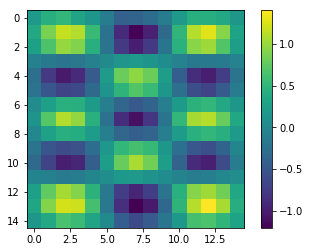

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

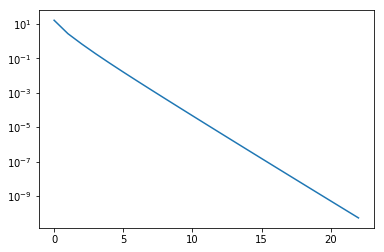

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.34774595024476124


In [16]:
wnew

array(0.80217911)

Rrestriction matrix after optimization

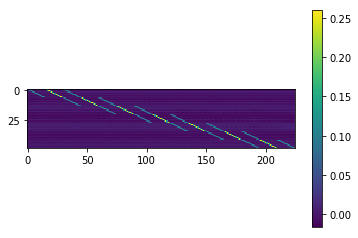

In [17]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

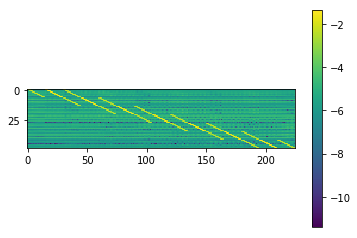

In [18]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

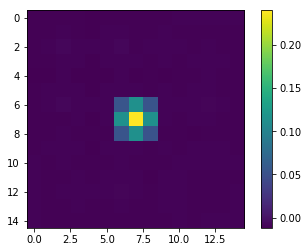

In [19]:
basis1 = Rnew[int(0.5*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

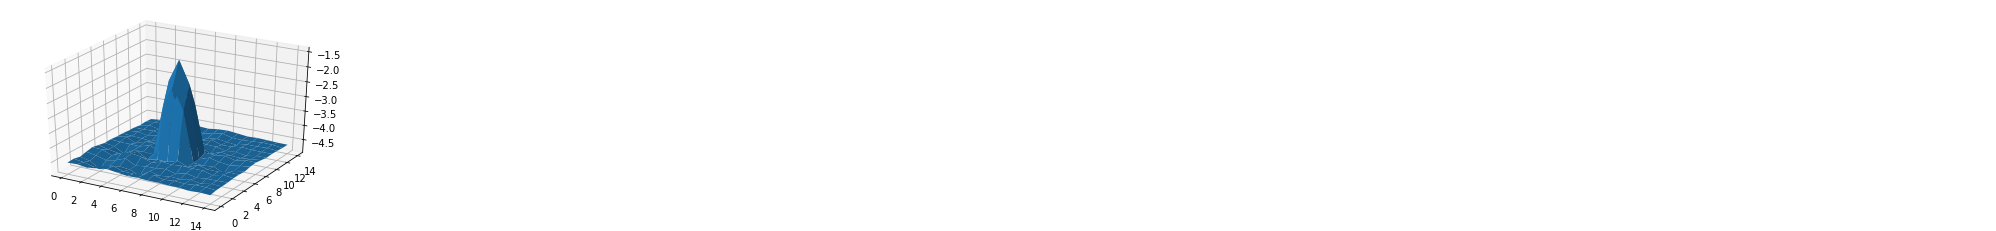

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(abs(basis1)))
plt.show()

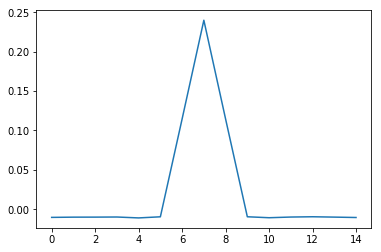

In [21]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

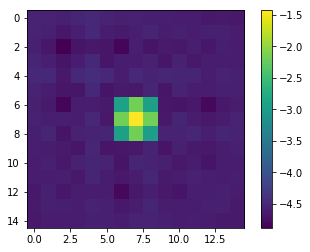

In [22]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

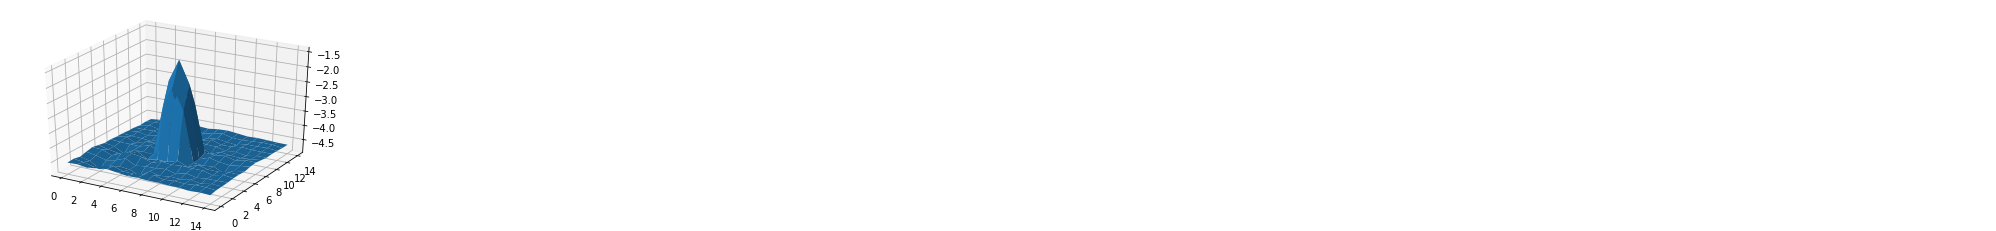

In [23]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

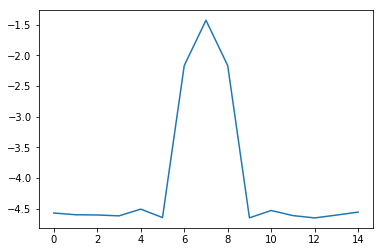

In [24]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
7.694727444094132
L2 norm: 
0.4810518755493511
H1 norm: 
5.4927770411127925
Energy norm: 
0.6644090000613291
L2 norm: 
0.9621037510987022
H1 norm: 
0.6686728269786312


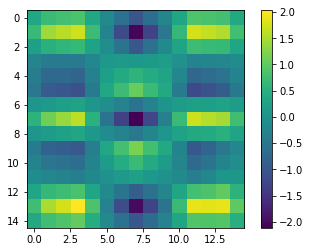

In [25]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [26]:
import os
os.system("say 'The program has finished, Please check the results'")

0